In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

In [2]:
%reload_ext autoreload

import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import scipy

In [4]:
from libs.plotting import plot_lcs
from astropy.table import Table

### Load data

In [5]:
from dataset import radio_mrk421, gev_mrk421, coincidence_mask_mrk421

from dataset import radio_mrk421_orig

from dataset import coincidence_checker
import matplotlib.pyplot as plt

### Define response profile and convolution routine¶

In [6]:
def profile_st(x, Amp, t_rise, t_fall, t_shift):
    t = x - t_shift
    return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))

def convolve_arrays_sigma(v1, v2, dv1):
    v1, v2, dv1 = np.array(v1), np.array(v2), np.array(dv1)
    r = np.convolve(v1, v2)
    dr2 = np.convolve(dv1 ** 2, v2 ** 2)
    return r, np.sqrt(dr2)

### Define fit configuration and fitting routines

In [7]:
def prepare_fit(s_data_ds, r_data_ds, bin_size, fit_roi, time_start=None, noplot=False):
    s_data = s_data_ds
    r_data = r_data_ds
    
    s_m, r_m = coincidence_checker(s_data, r_data, bin_size=bin_size)
    
    sd = Table({i:s_data_ds[i][s_m] for i in s_data_ds.columns})
    sd.meta = s_data_ds.meta
    for c in s_data_ds.columns:
        sd[c].unit = s_data_ds[c].unit
    
    rd = Table({i:r_data_ds[i][r_m] for i in r_data_ds.columns})
    rd.meta = r_data_ds.meta
    for c in r_data_ds.columns:
        rd[c].unit = r_data_ds[c].unit
    
    if not noplot:
        plot_lcs(sd, rd, extra_data=[s_data_ds, r_data_ds], highlights=[None, fit_roi], figsize=(10, 6))
    return s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd


def get_fit(params, 
            configuration, 
            profile_func, 
            t_shift=None, 
            const_flux_present=False, 
            all_uncertainties=False, 
            exclude_roi=[], 
            plot_data=False, 
            curvefit=False, 
            syn_delay=0, 
            result=False,  
            ylims=None, 
            start_time=None, 
            highlight=None,
            plot_timerange=None,
            dst_data=None, 
            color='black',
            extra_data=None,
            extra_color='#1f77b4', #'#11265b',
            filename='tmp.png',
            flare_tuning = None,
            background=None,
            extra_plot=None,
            get_dof = False,
            plot_flares=False
           ):
    s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd = configuration
    s_t, s_f, s_df = s_data['tc'], s_data['f'], s_data['df']
    r_t, r_f, r_df = r_data['tc'], r_data['f'], r_data['df']
    
    const_flux = 0
    if const_flux_present:
        const_flux = params[-1]
        params = params[:-1]        
    if t_shift is not None:
        params = [*params] + [t_shift]
    prof = profile_func(s_t - min(s_t), *params)
    _params = [i for i in params]
    A0 = params[0]
    syn_t = s_t
    syn_f = np.zeros_like(s_f)
    syn_df = np.zeros_like(s_df)
    if flare_tuning is None:
        syn = convolve_arrays_sigma(s_f.copy(), prof, s_df)
        syn_f = syn[0][:len(s_f)] + const_flux
        syn_df = syn[1][:len(s_f)]
    else:
        fig = None
        if plot_flares:
            fig = plt.figure(figsize=(15,5))
        for f in flare_tuning:
            _time_range, amplitude = f
            _tmp_s_f = np.zeros_like(s_f)
            _tmp_s_df = np.zeros_like(s_df)
            m = np.logical_and(syn_t > _time_range[0], syn_t <= _time_range[1])
            _tmp_s_f[m] = s_f.copy()[m]
            _tmp_s_df[m] = s_df.copy()[m]
            _params[0] = A0 * amplitude
            prof = profile_func(s_t - min(s_t), *_params)
            syn = convolve_arrays_sigma(_tmp_s_f, prof, _tmp_s_df)
            syn_f += syn[0][:len(s_f)]
            syn_df += syn[1][:len(s_f)]**2
            if plot_flares:
                plt.plot(s_t, syn[0][:len(s_f)] + const_flux, '.', label="%s" % _time_range)
        syn_t = s_t   
        if background is not None:
            syn_f += background(s_t, const_flux)
        else:
            syn_f += const_flux
        syn_df = 0*np.sqrt(syn_df)
        if plot_flares:
            plt.legend()
            plt.show()
        
    roi_mask = np.logical_and(r_t[r_m] >= fit_roi[0], r_t[r_m] <= fit_roi[1])
    
    _r_t = r_t[r_m][roi_mask]
    _r_f = r_f[r_m][roi_mask]
    _r_df = r_df[r_m][roi_mask]
    
    _s_t = syn_t[s_m][roi_mask]
    _s_f = syn_f[s_m][roi_mask]
    _s_df = syn_df[s_m][roi_mask]
    
    if curvefit:
        return np.column_stack([_r_t, _r_f, _r_df]), np.column_stack([_s_t, _s_f, _s_df])
    
    delta = _r_df
    if all_uncertainties:
        delta = np.sqrt(_r_df**2 + _s_df**2)
    
    xi = ((_s_f - _r_f)/delta)**2
    xi_t = _s_t
    for p in exclude_roi:
        m = np.logical_and(xi_t >= p[0], xi_t <= p[1])
        xi = xi[~m]
        xi_t = xi_t[~m]
    
    dof = len(xi) - len(params) - (1 if const_flux_present else 0)
    chi2 = np.sum(xi)
    
    if get_dof:
        return chi2/dof, dof
        
    if not plot_data:
        #clear_output(wait=True)
        #display("chi2 = %s (%s), params = %s, delta_t = %s" % (chi2, len(xi), np.array(params), t_shift))
        return chi2/dof
    else:
        p = [i for i in params]
        if const_flux_present:
            p += [const_flux]
            
        print("chi2/dof = %s/%s = %s, params = %s, t_shift=%s" % (chi2, dof, chi2/dof, str(p), t_shift))
    

        syn_full = Table({'tc' : syn_t + syn_delay, 'f' : syn_f, 'df' : syn_df})
        syn_full.meta['title'] = "Synthetic LC"
        syn_full.meta['f_units'] = "Jy"

        sn = Table({'tc' : _s_t + syn_delay, 'f' : _s_f, 'df' : _s_df})
        sn.meta['title'] = "Synthetic LC"
        sn.meta['f_units'] = "Jy"

                
        #plot_lcs(sd, sn, rd, extra_data=[s_data_ds, syn_full, r_data_ds], highlights=[None, fit_roi, fit_roi], figsize=(10, 10), filename='images/gev_syn_radio.eps')
        
        _highlight = fit_roi if highlight is None else highlight
        _dst_data = rd if dst_data is None else dst_data
        
        
        
        def inset_creator(ax):
            x = np.linspace(0, 700, 1000)
            A, t_rise, t_decay, f_const = 197765.3421157885, 19.24416937907919, 42.883458356259524, 26.973314037084446
            delta_t = 255
            p = profile_func(x - min(x), *params)
            ax.plot(x, p/np.max(p))
            ax.set_ylabel("$S/S_{max}$")
            ax.set_xlabel('$t$ (d)')

        
        plot_lcs(s_data, sn, _dst_data, extra_data=extra_data, extra_plot=extra_plot, highlights=[None, _highlight, _highlight, None], extra_color=extra_color, color=color, figsize=(11, 9), ylims=ylims, timerange=plot_timerange, filename=filename, inset_creator=inset_creator, inset_id=1)
       
        return sd, sn, rd, chi2, dof, _r_t, _r_f, _r_df, _s_t, _s_f, _s_df, syn_full

### Define fitting configurations

In [8]:
mrk421_timerange = [55500, gev_mrk421.meta['timerange'][1]]
mrk421_plot_timerange = [55200, gev_mrk421.meta['timerange'][1]]

con_f1d = prepare_fit(gev_mrk421, radio_mrk421, bin_size=1, fit_roi=mrk421_timerange, noplot=True)
con_plot = prepare_fit(gev_mrk421, radio_mrk421, bin_size=1, fit_roi=mrk421_plot_timerange, noplot=True)

### Perform fitting

In [9]:
from scipy.signal import savgol_filter
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import time

In [10]:
bounds = [
    [1e-12, 1e12],  #Amp
    [0.01, 1e12],    #t_rise
    [0.01, 1e12],    #t_fall
    [1e-12, 1e12]   #flux_const
]
methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
b_methods = ["L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr",]

res_7d = []
counter = 0
for r in np.arange(20, 60, 0.2):
    _v = optimize.minimize(
                              get_fit, 
                              [23535.20365754549, 0.015380723247993085, 73.78425436114611, 0.1386638679962689], # random guess
                              args = (con_f1d, profile_st, r, True, False), #configuration, profile_function, 
                                                                            #t_rise time, is_const_flux_present, all_uncertainties
                              method=b_methods[4], bounds=bounds,
                              #method=methods[0],
                              options={'disp': False, 'maxiter': 10000, 'xtol': 1e-09}
                            )
    if counter % 10 == 0:
        clear_output(wait=True)
    counter+=1
    print(r, "%.3f" % _v.fun, ", ".join(["%.3f" % i for i in _v.x]))
    res_7d.append([r, _v])

57.999999999999865 34.736 14353.553, 15.569, 105.789, 0.181
58.19999999999986 34.762 14370.593, 15.736, 105.589, 0.181
58.399999999999864 34.787 14387.633, 15.901, 105.389, 0.181
58.599999999999866 34.812 14403.116, 16.066, 105.202, 0.181
58.79999999999986 34.837 14419.177, 16.229, 105.011, 0.181
58.99999999999986 34.861 14446.512, 16.387, 104.725, 0.181
59.19999999999986 34.885 14440.591, 16.553, 104.719, 0.181
59.399999999999864 34.909 14465.559, 16.709, 104.453, 0.181
59.59999999999986 34.933 14466.293, 16.871, 104.391, 0.181
59.799999999999855 34.956 14510.797, 17.018, 103.964, 0.181


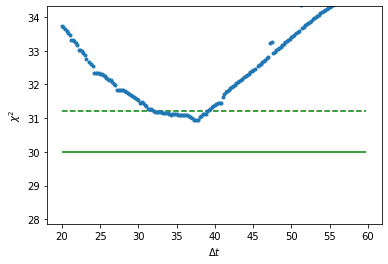

items:  34
32.20 [11895.319598335063, 0.01779022227792031, 134.8130079068906, 0.17193126856118485] 12.89830670193555
32.40 [11878.635636376519, 0.026040764820630377, 134.80071699201818, 0.17193503337917926] 12.897714876236865
32.60 [11885.281676844797, 0.29105259703221464, 134.61550651786035, 0.1719382210492057] 12.90481225695726
32.80 [11908.056325687307, 0.36708636809720085, 134.32151015734115, 0.1720495721441327] 12.902510793515324
33.00 [11932.21278660993, 0.43166139670829057, 134.0075002989737, 0.17217014331969407] 12.897570791462126
33.20 [12005.044661608663, 0.022102621574478218, 133.4149813528566, 0.1724357377667587] 12.83895084142111
33.40 [11971.602606935488, 0.488254121777171, 133.4839948186235, 0.17239077307923498] 12.888773532589243
33.60 [11991.552784024772, 0.4689245160581226, 133.21886847696055, 0.1725054987083954] 12.880504531283368
33.80 [12009.031751767507, 0.3774954389181689, 132.9865910232894, 0.17260905968362297] 12.866572908003837
34.00 [12030.987303130767, 0.069

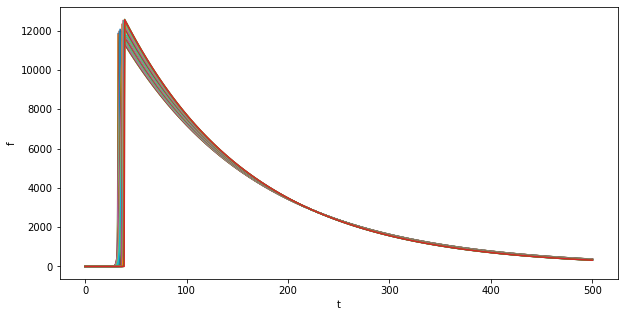

Best fit parameters:  [12545.323180753148, 0.02398711724499601, 126.53634204163151, 0.1751051882823516]
Delta t:  37.399999999999935


In [11]:
data = res_7d
min_chi2dof, max_chi2dof = 30.0, 31.2
ts, xs, fun = np.array([i[0] for i in data]), np.array([i[1].x for i in data]), np.array([i[1].fun for i in data])
plot_y_limits = [0.9*np.min(fun), 1.1*max_chi2dof]

plt.plot(ts, fun, '.')
plt.hlines(max_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='dashed')
plt.hlines(min_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='solid')
plt.ylim(plot_y_limits)
plt.xlabel("$\Delta t$")
plt.ylabel("$\chi^2$")
plt.show()

bf_params = xs[fun > min_chi2dof][np.argmin(fun[fun > min_chi2dof])]
bf_delta_t = ts[fun > min_chi2dof][np.argmin(fun[fun > min_chi2dof])]

m = np.logical_and(fun >= min_chi2dof, fun <= max_chi2dof)
xs, ts = xs[m], ts[m]
_f = fun[m]
print("items: ", len(xs))
fig = plt.figure(figsize=(10, 5))
x = np.linspace(0, 500, 1000)
for t, f, v in zip(ts, _f, xs):
    #params = list(v) + [t]
    #const_flux = 0
    #const_flux_present=False
    params = list(v[:-1]) + [t]
    const_flux = v[-1]
    const_flux_present=True
    plt.plot(x, profile_st(x, *params) + const_flux, '-')
    xi2 = get_fit(v, con_f1d, profile_st, t, const_flux_present, all_uncertainties=True)
    print("%.2f" % t, list(v), xi2)
plt.xlabel("t")
plt.ylabel("f")
plt.show()

print("Best fit parameters: ", list(bf_params))
print("Delta t: ", bf_delta_t)

### Plot resulting LCs

chi2/dof = 1595.9302656932496/262 = 6.091336891958968, params = [12545.323180753148, 0.02398711724499601, 126.53634204163151, 37.399999999999935, 0.1751051882823516], t_shift=37.399999999999935
Mrk 421 using UL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


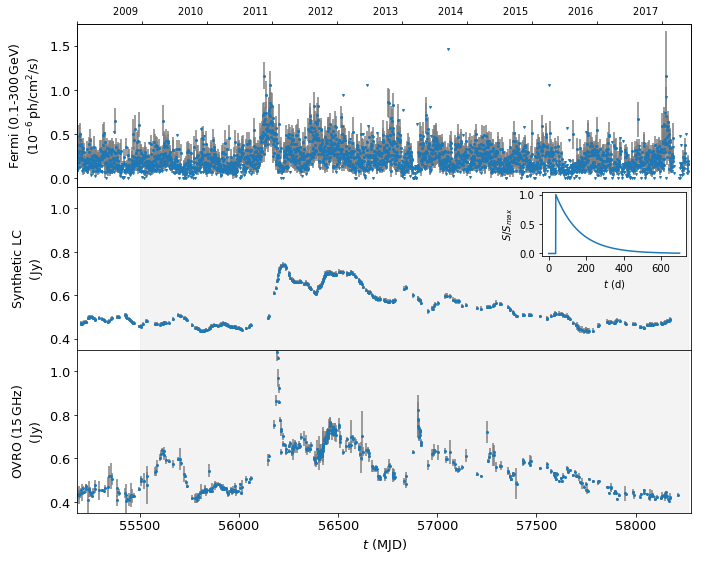

In [12]:
t = bf_delta_t
x = bf_params
ylims = [[None, None], [0.35, 1.1], [0.35, 1.1]]
exclude_roi=[
    [55550, 55650],
    [56150, 56250],
    [58850, 58950],
    [57200, 75300]
]
result = get_fit(x, con_plot, profile_st, t, True, extra_data=[gev_mrk421, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, exclude_roi=exclude_roi, highlight=mrk421_timerange, plot_timerange=mrk421_plot_timerange, dst_data=radio_mrk421_orig, color='#1f77b4', filename='images/gev_syn_radio_mrk421.eps')

### Estimate parameters uncertainties

In [13]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
#
params = list([bf_delta_t]) + list(bf_params)
x0, dof = get_fit(params[1:], con_f1d, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.8 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_f1d, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")

37.399999999999935 -0.08984984984984834 +0.09359359359359587 || 37.310150150150086 & 37.49359359359353
12545.323180753148 -12.557881061815351 +497.292090047873 || 12532.765299691333 & 13042.615270801021
0.02398711724499601 -0.004797423448999201 +0.011993558622498002 || 0.019189693795996807 & 0.03598067586749401
126.53634204163151 -0.12666300504668015 +0.13932930555134249 || 126.40967903658483 & 126.67567134718286
0.1751051882823516 -0.0004206731250026574 +0.008045373515675636 || 0.17468451515734895 & 0.18315056179802724
